# Intelligent Systems 3: Probabilistic and Deep Learning

Setup
- delete MACOSX in extracted images folder

### Question 1: Regression and classification (42 marks)
**a. Train and evaluate a least squares linear regression model predicting the value of
variable D from variables A, B and C.**

In [72]:
# This line is needed to use matplotlib in Jupyter notebook
%matplotlib inline
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale, normalize
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
np.set_printoptions(suppress=True)

# Imports the data for question 1 and 2
DATA = data = np.genfromtxt('data.csv', delimiter=',', skip_header=1, dtype=float)

def split_data(data, train_size):
    # Shuffles the data but always in the same way to valid comparisons of models
    np.random.seed(10)
    np.random.shuffle(data)

    # separates D as the target variable
    X, y = data[:,:-1], data[:,-1]

    # Splits the data into training and test sets
    X_train, X_test = X[:-train_size], X[-train_size:]
    y_train, y_test = y[:-train_size], y[-train_size:]
    return X_train, X_test, y_train, y_test, X, y

-------------------------------- QUESTION 1 (a) --------------------------------


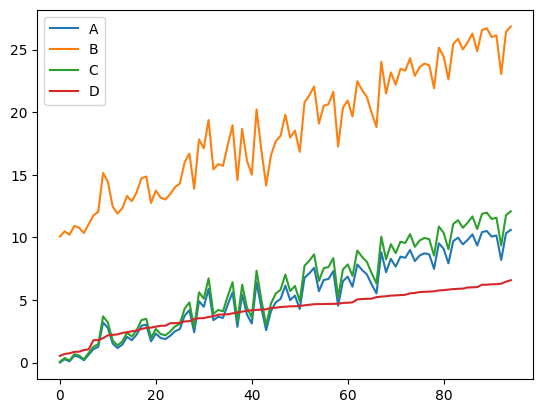

Coefficients of A, B & C: [-3.62624739e+12  8.71570713e+12 -8.97206622e+12]
Mean squared error: 0.33
Coefficient of determination (R2): 0.86

Cross-Validation Mean R2 Score: 0.87
----------------------------------------------------------------------------


In [73]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def least_squares_regression(data, train_size, v=0, log=True, plot=True):
    """Runs linear least squares regression on the data. 
    Normalises and scales the data if specified.
    v=0 no preprocessing, v=1 normalise, v=2 scale, v=3 normalise and scale."""

    # Creates a copy of the data so the original data is not modified by the function
    data = deepcopy(data)
    
    if v == 1 or v == 3:
            data = normalize(data, axis=0) # axis=0 normalises the data by feature

    if v == 2 or v == 3:
            data = scale(data)

    if v == 4 or v == 6:
            minmax = MinMaxScaler()
            data = minmax.fit_transform(data)

    if v == 5 or v == 6:
            scaler = StandardScaler()
            data = scaler.fit_transform(data) 
    
    if plot:
        df = pd.DataFrame(data, columns = ['A','B','C', 'D'])
        df.plot()
        plt.show()
    
    # Splits the data into training and test sets
    X_train, X_test, y_train, y_test, X, y = split_data(data, train_size)

    # Train model and make predictions
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

    # Test of generalisation (10-fold cross-validation)
    scores = cross_val_score(regr, X, y, cv=10)

    # Prints the results
    if log:
        print("Coefficients of A, B & C:", regr.coef_)
        print('Mean squared error: %.2f'
            % mean_squared_error(y_test, y_pred))
        print('Coefficient of determination (R2): %.2f'
            % r2_score(y_test, y_pred))
        print("\nCross-Validation Mean R2 Score: " + str(scores.mean().round(2)))

    return regr, scores.mean()

print("-" * 32 + " QUESTION 1 (a) " + "-" * 32)
least_squares_regression(data=DATA, train_size=75)
print("-" * 76)

**b. Repeat the above task after carrying out in turn data normalisation, data scaling and
their combination, and evaluate the benefits of each of these 3 types of data preprocessing.**

Below shows the affect of data normalisation, data scaling and the combination of the two before performing the previous linear regression.

[Normalisation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html): Scale input vectors individually to unit norm (vector length)

[Scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html#sklearn.preprocessing.scale): Standardize a dataset along any axis. Center to the mean and component wise scale to unit variance.

As shown by the R2 values for the three types of data preprocessing (and mean r2 values when running cross validation), none have had a significant impact on the efficiency of the model. This is likely due to the fact that its not neccessary to normalise or scale the data when using linear regression as the coefficients learned by the model are not affected by the scale of the input features. 

However, standardizing the data can be useful as it makes it easier to interpret the coefficients that the model has learned. For instance, if one features scale is much larger than anothers, then the coefficient for that feature may also be larger in comparison to other features with smaller scales. Standardizing prevents this as all features are on the same scale. For example, it has shown that A, B and C all affect the value for D equally. We can prove this by plotting the original data vs the scaled data which is shown below. 



-------------------------------- QUESTION 1 (b) --------------------------------
Original Data:


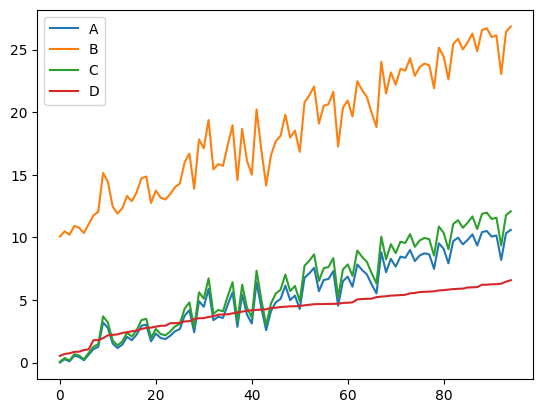

Data Normalisation:


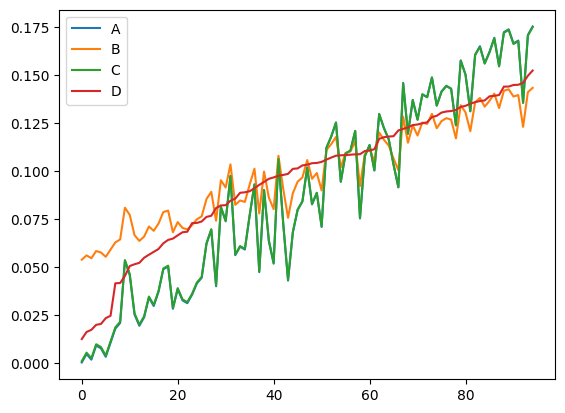

Coefficients of A, B & C: [-3.11051498e+13  1.46393674e+13  2.37649427e+13]
Mean squared error: 0.00
Coefficient of determination (R2): 0.88

Cross-Validation Mean R2 Score: 0.87
----------------------------------------------------------------------------
Data scaling


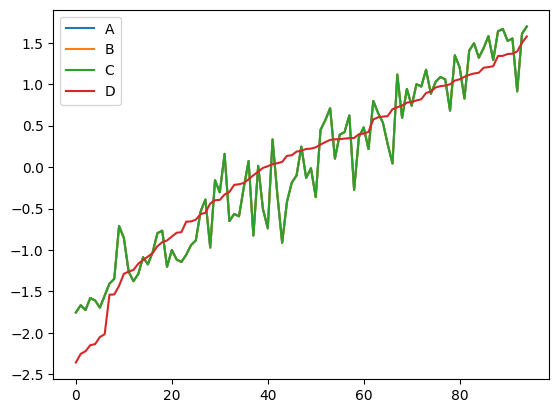

Coefficients of A, B & C: [0.33486256 0.33486256 0.33486256]
Mean squared error: 0.13
Coefficient of determination (R2): 0.88

Cross-Validation Mean R2 Score: 0.87
----------------------------------------------------------------------------
Norm then Scale


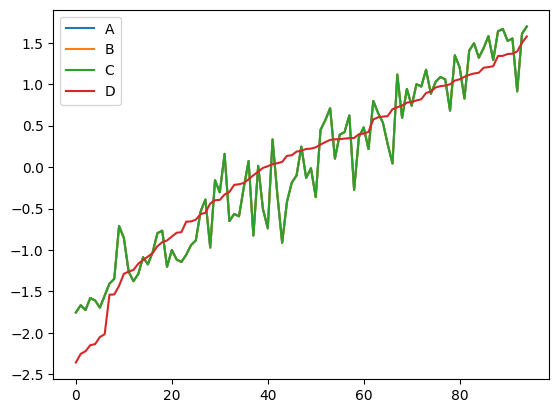

Coefficients of A, B & C: [0.33486256 0.33486256 0.33486256]
Mean squared error: 0.13
Coefficient of determination (R2): 0.88

Cross-Validation Mean R2 Score: 0.87
----------------------------------------------------------------------------


In [74]:
print("-" * 32 + " QUESTION 1 (b) " + "-" * 32)

print("Original Data:")
df = pd.DataFrame(data, columns = ['A','B','C', 'D'])
df.plot()
plt.show()


# 1. Performs Data Normalisation - using lecture example
print("Data Normalisation:")
least_squares_regression(data=DATA, train_size=75, v=1)
print("-" * 76)

# 2. Performs Data Scaling - using lecture example
print("Data scaling")
least_squares_regression(data=DATA, train_size=75, v=2)
print("-" * 76)

# 3. Performs Data Normalisation and Data Scaling - using lecture examples
print("Norm then Scale")
least_squares_regression(data=DATA, train_size=75, v=3)
print("-" * 76)

**c. Try to outperform the best result of the previous step by using regularisation (e.g. L1,
L2 or Elastic Net). Show how any parameter values are tuned and evaluate the benefits of
regularisation.**

The use of regularisation has been implemented by using RidgeCV regression. The data was first pre-processed by standardising it - removing the mean and scaling to unit variance. This is important as if features have different scales, then the penalty term will have a different effect on the coefficients of the features, depending on their scale. This can mean that the model may give more weight to features with larger scales, potentially ignoring smaller ones.

The alpha value was determined by using cross-validation to determine the most successful value from the following list `[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]`. The value chosen was 0.1.

In comparison to the previous regressions, this model has not performed any better, producing an identical R2 (and cross valided mean R2) value. As shown previously, we can see that the 3 features (A, B & C) are direct translations of each other. Its generally not a good idea to use highly correlated features in any type of regularized linear regression. The penalty term is not likely to be able to effectively determine any unimportant features as once scaled these features are identical (shown by the coefficients of A, B & C being identical). This therefore means that the addition of the penalty term had no additional effect.


In [75]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def regularisation(data, train_size, log=True):
    # Creates a copy of the data so the original data is not modified by the function
    data = deepcopy(data)

    # Splits the data into training and test sets
    X_train, X_test, y_train, y_test, X, y = split_data(data, train_size)

    pipe = Pipeline([('Scaler', StandardScaler()), ('RidgeCV', RidgeCV(alphas=np.logspace(-6, 6, 13)))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Test of generalisation (10-fold cross-validation)
    scores = cross_val_score(pipe, X, y, cv=10)

    if log:
        print('Testing complexity parameter values (i.e.alphas): ', np.logspace(-6, 6, 13))
        print('Cross-validation got this value for the complexity parameter: ', pipe.named_steps['RidgeCV'].alpha_)
        for i, name in enumerate(["A", "B", "C"]):
            print('Coefficient for {0} is {1}'.format(name,pipe.named_steps['RidgeCV'].coef_[i]))
        print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
        print('Coefficient of determination (R2): %.2f' % r2_score(y_test, y_pred))
        print("\nCross-Validation Mean R2 Score: " + str(scores.mean().round(2)))

    return pipe, scores.mean()

print("-" * 32 + " QUESTION 1 (c) " + "-" * 32)
regularisation(data=DATA, train_size=75)
print("-" * 76)

-------------------------------- QUESTION 1 (c) --------------------------------
Testing complexity parameter values (i.e.alphas):  [      0.000001       0.00001        0.0001         0.001
       0.01           0.1            1.            10.
     100.          1000.         10000.        100000.
 1000000.      ]
Cross-validation got this value for the complexity parameter:  0.1
Coefficient for A is 0.4549582578547384
Coefficient for B is 0.4549582578547342
Coefficient for C is 0.4549582578547271
Mean squared error: 0.30
Coefficient of determination (R2): 0.88

Cross-Validation Mean R2 Score: 0.87
----------------------------------------------------------------------------


**4. Add a set of suitable basis functions to the original data and train a linear regression
with an appropriate type of regularisation to find out which of the new basis functions bring
benefits. Explain briefly (in no more than 4 sentences) your reasoning.**

As previously mentioned, when scaled AB and C are all identical, making a lot of the basis functions added using PolynomialFeatures redundant. For example, $A^2B$ is identical to $A^3$. Therefore only 3 coefficients have been identified from the new basis functions which are:

- Linear (A, B, C) = 0.35
- Squared (A^2, AB, etc.) = -0.0661
- Cubed (A^3, ABC, etc.)= 0.0137

The mean R2 score for this model is higher than the normal regularisation. This suggests the small negative relationship for the squared functions and the small positive relationship of the cubed functions has slightly improved the predictions.



In [76]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

def polynomial_regression(data, train_size, log=True):
    data = deepcopy(data)
    
    # splits the data into training and test sets
    X_train, X_test, y_train, y_test, X, y = split_data(data, train_size)

    pipe = Pipeline([('Scaler', StandardScaler()), ("BasisFunctions", PolynomialFeatures(3)), ("RidgeCV", RidgeCV(alphas=np.logspace(-6, 6, 13)))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Test of generalisation (10-fold cross-validation)
    scores = cross_val_score(pipe, X, y, cv=10)

    if log:
        print('Cross-validation got this value for the complexity parameter: ', pipe.named_steps['RidgeCV'].alpha_)
        for i, name in enumerate(["1 (bias)", "A", "B", "C", "A^2", "AB", "AC", "B^2", "BC", "C^2", "A^3", "(A^2)B", "(A^2)C", "A(B^2)", "ABC", "A(C^2)", "B^3", "(B^2)C", "B(C^2)", "C^3"]):
            print('Parameter for {0} is {1}'.format(name,pipe.named_steps['RidgeCV'].coef_[i]))
        print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
        print('Coefficient of determination (R2): %.2f' % r2_score(y_test, y_pred))
        print("\nCross-Validation Mean R2 Score: " + str(scores.mean().round(2)))

    return pipe, scores.mean()

print("-" * 32 + " QUESTION 1 (d) " + "-" * 32)
polynomial_regression(DATA, 75)
print("-" * 76)


-------------------------------- QUESTION 1 (d) --------------------------------
Cross-validation got this value for the complexity parameter:  1e-06
Parameter for 1 (bias) is 0.0
Parameter for A is 0.34744507528375834
Parameter for B is 0.34744507528375834
Parameter for C is 0.347445075167343
Parameter for A^2 is -0.06617243500659242
Parameter for AB is -0.0661724345991388
Parameter for AC is -0.06617243494838476
Parameter for B^2 is -0.06617243378423154
Parameter for BC is -0.06617243424989283
Parameter for C^2 is -0.06617243465734646
Parameter for A^3 is 0.013663789024576545
Parameter for (A^2)B is 0.013663789257407188
Parameter for (A^2)C is 0.013663789024576545
Parameter for A(B^2) is 0.013663789723068476
Parameter for ABC is 0.013663789257407188
Parameter for A(C^2) is 0.013663789024576545
Parameter for B^3 is 0.01366379065439105
Parameter for (B^2)C is 0.013663789723068476
Parameter for B(C^2) is 0.013663789490237832
Parameter for C^3 is 0.013663788791745901
Mean squared error: 

**5. Implement an appropriate automated procedure that will train all of the above models
and select the model expected to perform best on unseen data with the same distribution as your
training data. You need to include a code tile at the end of this section of your Jupyter notebook
that attempts to test your final choice of model on a data set stored in a file unseendata.csv
and compute $R^2$ for it. The file will have exactly the same format as file data.csv, including
the header, but possibly a different overall number of rows. This means you can use a renamed
copy of data.csv to debug that part of your code, and to produce the corresponding content
for your PDF file (in order to demonstrate that this part of the code is in working order).**

This function takes the data as input and trains all of the models and calculated their mean 10 fold cross validation scores. The model with the highest cross validation score has been chosen to train against the unseendata.csv.


In [77]:
def choose_best_model(data, train_size):
    """Returns the model with the highest averaged cross-validation r2 score."""
    i, name, best_model, best_model_CV_mean = 1, None, None, None

    for v in range(0, 3):
        regr, cv_mean = least_squares_regression(data, train_size, v, log=False, plot=False)
        if v == 0:
                mod_name = "Linear Regression"
        elif v == 1:
            mod_name = "Linear Regression with Normalisation"
        elif v == 2:
            mod_name = "Linear Regression with Standardisation"
        elif v == 3: 
            mod_name = "Linear regression with Normalisation and Standardisation"
        if best_model_CV_mean is None or cv_mean > best_model_CV_mean:
            name, best_model, best_model_CV_mean = mod_name, regr, cv_mean
        print(f"{i}. {mod_name} has a mean r2 score of {cv_mean.round(2)}")
        i += 1
            
    regr, cv_mean = regularisation(data, train_size, log=False)
    mod_name = "Regularisation"
    if cv_mean > best_model_CV_mean:
        best_model, best_model_CV_mean = regr, cv_mean
        name = mod_name
    print(f"{4}. {mod_name} has a mean r2 score of {cv_mean.round(2)}")
    
    regr, cv_mean = polynomial_regression(data, train_size, log=False)
    mod_name = "Linear regression with polynomial basis functions"
    if cv_mean > best_model_CV_mean:
        best_model, best_model_CV_mean = regr, cv_mean
        name = mod_name
    print(f"{5}. {mod_name} has a mean r2 score of {cv_mean.round(2)}")
    
    print("\nThe best model to perform on unseen data is " + name + " as it has the highest mean r2 score of " + str(best_model_CV_mean.round(2)) + " after running 10-fold cross validation\n")
    
    return best_model

def test_unseen(best_model):
    """Runs the best model on the unseen data. Prints the mean squared error and R2 score."""
    unseen_data = np.genfromtxt('unseendata.csv', delimiter=',', skip_header=1, dtype=float)
    X, y = unseen_data[:,:-1], unseen_data[:,-1]
    y_pred = best_model.predict(X)
    print("Running on unseendata.csv...")
    print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
    print('Coefficient of determination (R2): %.2f' % r2_score(y, y_pred))

print("-" * 32 + " QUESTION 1 (e) " + "-" * 32)
best_model = choose_best_model(DATA, 75)
test_unseen(best_model)
print("-" * 76)

-------------------------------- QUESTION 1 (e) --------------------------------
1. Linear Regression has a mean r2 score of 0.87
2. Linear Regression with Normalisation has a mean r2 score of 0.87
3. Linear Regression with Standardisation has a mean r2 score of 0.87
4. Regularisation has a mean r2 score of 0.87
5. Linear regression with polynomial basis functions has a mean r2 score of 0.91

The best model to perform on unseen data is Linear regression with polynomial basis functions as it has the highest mean r2 score of 0.91 after running 10-fold cross validation

Running on unseendata.csv...
Mean squared error: 0.21
Coefficient of determination (R2): 0.91
----------------------------------------------------------------------------


6. Starting with the data in data.csv, find the median value of variable D. Replace all
values up to and including the median value with 0, and all values greater than that with 1. Treat
the resulting values of D as class labels to train and evaluate a classifier based on logistic
regression that takes variables A, B and C as input.

In [78]:
def logistic_regression(data, train_size):
    # Replaces the last column with 1 if the value is greater than the median, 0 otherwise.
    median = np.median(data[:, 3])
    data[:, 3] = np.where(data[:, 3] > median, 1, 0)

    # Splits the data into training and test sets
    X_train, X_test, y_train, y_test, X, y = split_data(data, train_size)

    # Runs logistic regression
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train, y_train)

    predictions = logisticRegr.predict(X_test)
    probability_predictions = logisticRegr.predict_proba(X_test)

    # Shows first 5 predictions
    print("First 5 example predictions:")
    for i in range(5):
        print("Predicted class:", predictions[i], "(Probability:" + str(probability_predictions[i][int(predictions[i])].round(4)) + ")")

     # Use score method to get out of sample accuracy of the model (2 decimal places)

    score = logisticRegr.score(X_test, y_test)
    print("\nOut of sample accuracy = " + str(score.round(2)*100) + "%")

    # Test of generalisation (10-fold cross-validation)
    scores = cross_val_score(logisticRegr, X, y, cv=10)

    print("\nCross-Validation Mean Out of Sample Accuracy: " + str(scores.mean().round(2)*100) + "%")

print("-" * 32 + " QUESTION f (d) " + "-" * 32)
logistic_regression(DATA, 75)
print("-" * 76)

-------------------------------- QUESTION f (d) --------------------------------
First 5 example predictions:
Predicted class: 1.0 (Probability:0.9586)
Predicted class: 0.0 (Probability:0.9835)
Predicted class: 0.0 (Probability:0.997)
Predicted class: 0.0 (Probability:0.857)
Predicted class: 1.0 (Probability:0.596)

Out of sample accuracy = 93.0%

Cross-Validation Mean Out of Sample Accuracy: 92.0%
----------------------------------------------------------------------------


# Question 2: Principal Component Analysis (8 marks)
**Starting with the same data.csv file from Q1, extend the table with 6 additional columns
consisting of the product of each pair of the original 4 variables A, B, C and D.
Apply principal component analysis (PCA) with a number of principal components (PCs) equal to
the number of original variables, i.e. p = 4. Label the resulting principal components in
decreasing order of variance as PC1. . .PC4 and list the linear equations showing how each of
them is calculated from the 10 input variables. Describe which variables affect most strongly
each of the 4 principal components, highlighting any notable findings and providing plausible
explanations for them.**

PCA is affected by scale, therefore the data has been scaled using the standard scaler from sklearn. Similar to previous questions, the variables A, B and C may as well be equal once they are scaled. Therefore all coefficients relating to these three are similar.

- PC1 - This component is most strongly affected by the products of D and the three other variables (AD, BD, CD) with a coefficient of 0.42. This suggests that as any of these variables increase so do the others. The products of A, B and C (AB, BC, AC) also have a coefficient of 0.35 which again suggests that as each of them increases so do the others. This is expected as we have already noted that A, B and C are all translations of the same data in the y direction. This does however note that D causes a slightly higher increase. This is a significant component and accounts for 59% of the variance.
- PC2 - This component is most strongly affected by the basic variables A, B, C with identical coefficients of 0.48. D also has a coefficient of 0.43. This suggests that as A B and C increase, D also increases but slightly less. This is a significant component and accounts for 39% of the variance.
- PC3 - This component is most strongly affected positively by variable D with a coefficient of 0.35, as well as all of the product variables of AB or C with a coefficient 0.4. Any product with D also significantly affects it negatively (-0.33). However the variance represented by this is only 1.5%.
- PC4 - This component is most strongly affected positively by variable D with a coefficient of 0.8. However, this only represents 0.4% of the variance.


In [79]:
from sklearn.decomposition import PCA
from itertools import combinations

data = np.loadtxt('data.csv',delimiter=',',skiprows=1)
scaler = StandardScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)

# extend the table with 6 additional column consisting of the product of each pair of the original 4 variables A, B, C and D
# A, B, C, D, AB, AC, AD, BC, BD, CD

for i, j in combinations(range(4), 2):
    scaled_data = np.hstack((scaled_data, np.atleast_2d(np.multiply(scaled_data[:, i], scaled_data[:, j])).T))


pca = PCA(n_components=4)
pca.fit(scaled_data)
newData = pca.fit_transform(scaled_data)


cols = ["A", "B", "C", "D", "AB", "AC", "AD", "BC", "BD", "CD"]
explained_variance = pca.explained_variance_ratio_
principal_components = pca.components_

NewTotVar = 0
for i, dim in enumerate(('PC1','PC2','PC3','PC4')):
  print('Sample variance for the {0} dimension'.format(dim))
  print('var = {0}'.format(explained_variance[i]))
  print('Linear Equation for the {0} dimension'.format(dim))
  linear_eq = "+".join(["(" + "{:.2f}".format(coeff) + "*" + col + ")" for coeff, col in zip(principal_components[i], cols)])
  print(linear_eq)
  print("\n")


Sample variance for the PC1 dimension
var = 0.5931250017147633
Linear Equation for the PC1 dimension
(-0.15*A)+(-0.15*B)+(-0.15*C)+(-0.22*D)+(0.35*AB)+(0.35*AC)+(0.42*AD)+(0.35*BC)+(0.42*BD)+(0.42*CD)


Sample variance for the PC2 dimension
var = 0.3880987110545241
Linear Equation for the PC2 dimension
(0.48*A)+(0.48*B)+(0.48*C)+(0.43*D)+(0.17*AB)+(0.17*AC)+(0.11*AD)+(0.17*BC)+(0.11*BD)+(0.11*CD)


Sample variance for the PC3 dimension
var = 0.014611021191387269
Linear Equation for the PC3 dimension
(-0.17*A)+(-0.17*B)+(-0.17*C)+(0.35*D)+(0.40*AB)+(0.40*AC)+(-0.33*AD)+(0.40*BC)+(-0.33*BD)+(-0.33*CD)


Sample variance for the PC4 dimension
var = 0.004165266039325376
Linear Equation for the PC4 dimension
(-0.23*A)+(-0.23*B)+(-0.23*C)+(0.80*D)+(-0.17*AB)+(-0.17*AC)+(0.20*AD)+(-0.17*BC)+(0.20*BD)+(0.20*CD)




# Question 3

classification, multiclass -> unconstrainted  use softmax to convert to probability distribution
compare estimated probability dis with correct one by using cross entropy loss
black + white image means 2d tensor

number of items = batch size first dimension of tensor
channels or features are special dimension

https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00

https://medium.com/analytics-vidhya/augment-your-data-easily-with-pytorch-313f5808fc8b

https://www.learnpytorch.io/04_pytorch_custom_datasets/

In [80]:
import torch
import os
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import torch.nn as nn
import math
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import SGD
from time import time
from PIL import Image

BATCH_SIZE = 64

## Splitting into test/train datasets
- unbalanced dataset so needs to be split carefully. 
- initially loads all images in using ImageFolder class, then this is analysed to show number of classes
- to split it up equally, used train_test_split from sklearn on the indicies, using stratisfying on the output classes. 
- Split ratio 80% train 20% test
- the overall dataset and the test and training dataset have been plotted.

Total data set:  16828
Class 0 has 6000 samples - 35.65%
Class 1 has 181 samples - 1.08%
Class 2 has 606 samples - 3.60%
Class 3 has 3685 samples - 21.90%
Class 4 has 6356 samples - 37.77%


Train set:  13462
Class 0 has 4800 samples - 35.66%
Class 1 has 145 samples - 1.08%
Class 2 has 485 samples - 3.60%
Class 3 has 2948 samples - 21.90%
Class 4 has 5084 samples - 37.77%


Test set:  3366
Class 0 has 1200 samples - 35.65%
Class 1 has 36 samples - 1.07%
Class 2 has 121 samples - 3.59%
Class 3 has 737 samples - 21.90%
Class 4 has 1272 samples - 37.79%




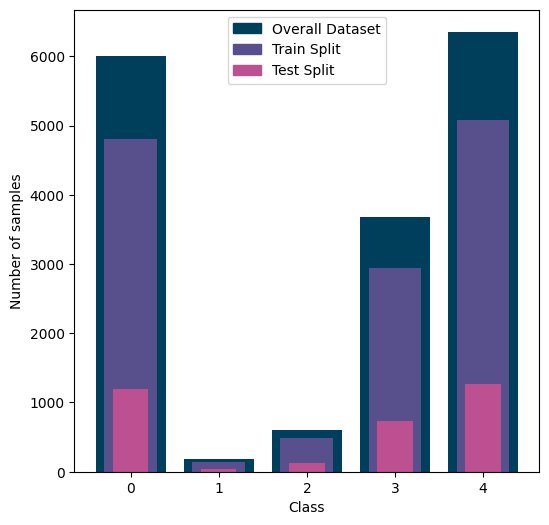

In [81]:
def print_split_stats(counts):
    total = sum(counts.values())
    for k, v in sorted(counts.items()):
        print(f"Class {k} has {v} samples - {v/total*100:.2f}%")
    print("\n")

figure = plt.figure(figsize=(6, 6))
plt.xlabel("Class")
plt.ylabel("Number of samples")

data = datasets.ImageFolder(root='images', transform=transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()]))
total_num_classes = Counter(data.targets)
print("Total data set: ", sum(total_num_classes.values()))
print_split_stats(total_num_classes)
plt.bar(total_num_classes.keys(), total_num_classes.values(), color='#003f5c')

indices = list(range(len(data)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, stratify=data.targets)

train_dataset = Subset(data, train_indices)
num_class_train = Counter(data.targets[i] for i in train_indices)
print("Train set: ", sum(num_class_train.values()))
print_split_stats(num_class_train)
plt.bar(num_class_train.keys(), num_class_train.values(), width=0.6, color='#58508d')

test_dataset = Subset(data, test_indices)
num_class_test = Counter(data.targets[i] for i in test_indices)
print("Test set: ", sum(num_class_test.values()))
print_split_stats(num_class_test)
plt.bar(num_class_test.keys(), num_class_test.values(), width=0.4, color='#bc5090')

overall_patch = mpatches.Patch(color='#003f5c', label='Overall Dataset')
train_patch = mpatches.Patch(color='#58508d', label='Train Split')
test_patch = mpatches.Patch(color='#bc5090', label='Test Split')

plt.legend(handles=[overall_patch, train_patch, test_patch]);

## Loading the Batches
- Much lower number of samples for some of the classes where as other classes have lots of samples. 
- Don’t want a training batch to contain samples just from the few classes with lots of samples. 
- Ideally, a training batch should contain represent a good spread of the dataset. 
- In PyTorch this can be achieved using a weighted random sampler.

- Define the weights for each class which would be inversely proportional to the number of samples for each class. USe this to define a sampler, then use this as the sampler for the data loader. 
- Weighted sampler is not needed for the test set so the sampler is not defined here. 

In [82]:
y_train = [data.targets[i] for i in train_indices]
class_sample_count = np.array([v for _, v in sorted(num_class_train.items())])
weight = 1. / torch.tensor(class_sample_count).float()
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

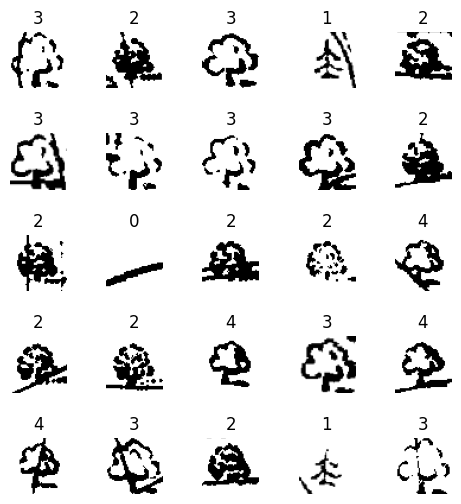

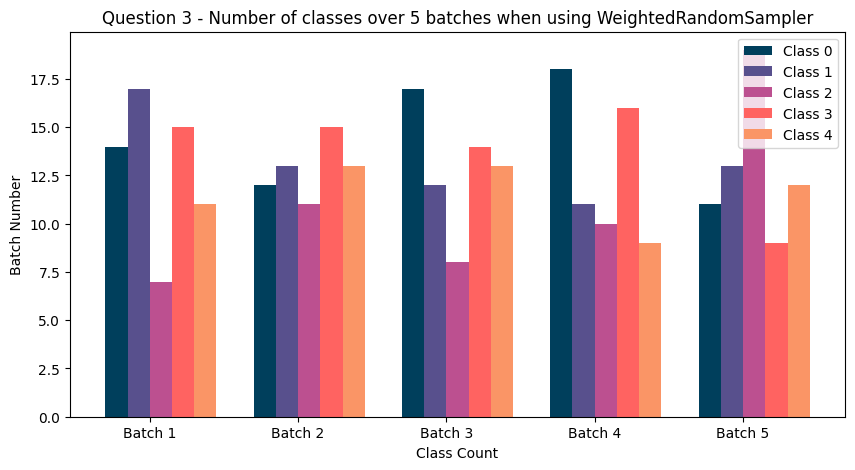

In [83]:
images, labels = next(iter(train_dataloader))

figure = plt.figure(figsize=(6, 6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.8)
cols, rows = 5, 5
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.title(labels[i].item())
    plt.axis("off")
    plt.imshow(images[i,:].squeeze(), cmap="gray")
plt.show()

labels = ["Batch " + str(i) for i in range(1, 6)]
counts = [[] for i in range(5)]
for i in range(5):
    images, lab = next(iter(train_dataloader))
    for k, v in Counter(lab.numpy()).items():
        counts[k].append(v)
colours = ["#003f5c", "#58508d", "#bc5090", "#ff6361", "#FA9566"]

N = 5

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.15  

# Plotting
for i in range(5):
    plt.bar(ind + (width*i), counts[i] , width, label=labels[i], color=colours[i])

plt.xlabel('Class Count')
plt.ylabel('Batch Number')
plt.title('Question 3 - Number of classes over 5 batches when using WeightedRandomSampler')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + ((width*3) / 2), labels)

# Finding the best position for legends and putting it
plt.legend(loc='best', labels=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"])
plt.show()

Parameters will only increase as we increase the number of hidden layers. So, the two major disadvantages of using artificial neural networks are:

Loses spatial orientation of the image
The number of parameters increases drastically
https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

This is where convolutional neural networks can be really helpful. CNNs help to extract features from the images which may be helpful in classifying the objects in that image. 

https://medium.com/analytics-vidhya/deep-learning-basics-batch-normalization-ae105f9f537e

batch norming ^

```
[(W−K+2P)/S]+1
```
    


In [84]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.ConvolutionalLayers = nn.Sequential(
            
        # First convolutional layer
        nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, stride=1, padding=1), # output size = B × 12 × 48 x 48
        nn.BatchNorm2d(12),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), # output size = B × 12 × 24 x 24
        nn.Dropout(0.2),

        # Second Convolutional layer
        nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1), # output size = B × 24 × 24 x 24
        nn.BatchNorm2d(24),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2), # output size = B × 24 × 12 x 12
        nn.Dropout(0.2),
        )


        self.MLP = nn.Sequential(
            
		nn.Linear(in_features=12*12*24, out_features=300),
        nn.BatchNorm1d(300),
		nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(in_features=300, out_features=180),
        nn.BatchNorm1d(180),

		# initialize our softmax classifier
		nn.Linear(in_features=180, out_features=5),
		nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        # Input x has dimensions B x 1 x 48 x 48, B is batch size
        x = self.ConvolutionalLayers(x)
        x = x.view(x.size(0), -1)
        x = self.MLP(x)
        # Output has dimensions B x 5
        return x

In [85]:
model = NeuralNetwork()
loss_func = nn.NLLLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [86]:
optimizer = SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 10

for e in range(epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = loss_func(output, labels)
    
        # Training pass
        optimizer.zero_grad()
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        if (i+1) % 60 == 0:
            print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(e + 1, epochs, i + 1, len(train_dataloader), loss.item()))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
torch.save(model.state_dict(), 'weights.pkl')

In [ ]:
import time

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

check_accuracy(test_dataloader, model)

# Run a test batch through the network
images, labels = next(iter(test_dataloader))
images, labels = images.to(device), labels.to(device)
output = model(images)
pred_y = torch.argmax(output, 1)

# Display first 25 images with predicted labels
figure = plt.figure(figsize=(10, 8))
for i in range(25):
    figure.add_subplot(5, 5, i+1)
    plt.title("{}/{}".format(labels[i], pred_y[i]))
    plt.axis("off")
    plt.imshow(images[i,:].squeeze().cpu(), cmap="gray")
plt.show()

# Question 4

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets, transforms
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler
import matplotlib.pyplot as plt
from PIL import Image


%matplotlib inline
import matplotlib.pyplot as plt

In [88]:
#TODO: custom dataset to load in everything except background images

class CGANImageDataset(Dataset):
    def __init__(self, root, image_dirs, transform=None):
        self.root = root
        self.transform = transform
        self.all_images = []
        self.labels = []
        i = 0
        for dir in image_dirs:
            dir_path = root + "/" + image_dirs[i]
            self.all_images += [img for img in os.listdir(dir_path) if img.endswith(".tif")]
            self.labels += [i for img in os.listdir(dir_path) if img.endswith(".tif")]
            i+=1

    def __len__(self):
        return len(self.all_img)

    def __getitem__(self, idx):
        label = self.labels[idx] 
        image = Image.open(self.root + "/class_" + str(label+1) + "/" + self.all_images[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

In [89]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

CGAN_EPOCHS = 5
GEN_INPUT_Z = 100
BATCH_SIZE = 64

CGAN_data = CGANImageDataset('images', ["class_1", "class_2", "class_3", "class_4"], transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor(), transforms.Resize((28, 28)), 
                                                                                transforms.Normalize(0.5,0.5)]))                                                            

In [90]:
cgan_y_train = CGAN_data.labels
num_class_gan_train = Counter(cgan_y_train)
cgan_class_sample_count = np.array([v for _, v in sorted(num_class_gan_train.items())])
cgan_weight = 1. / torch.tensor(cgan_class_sample_count).float()
cgan_samples_weight = np.array([cgan_weight[t] for t in cgan_y_train])
cgan_samples_weight = torch.from_numpy(cgan_samples_weight)

In [91]:
sampler = torch.utils.data.WeightedRandomSampler(cgan_samples_weight, len(cgan_samples_weight))
CGAN_dataloader=torch.utils.data.DataLoader(CGAN_data, batch_size=BATCH_SIZE, sampler = sampler, drop_last=True)

In [92]:
images, labels = next(iter(CGAN_dataloader))

hi1


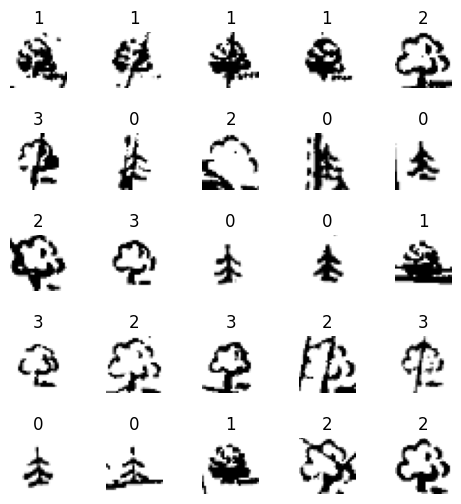

In [93]:
print("hi1")
figure = plt.figure(figsize=(6, 6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.8)
cols, rows = 5, 5
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.title(labels[i].item())
    plt.axis("off")
    plt.imshow(images[i,:].squeeze(), cmap="gray")
plt.show()

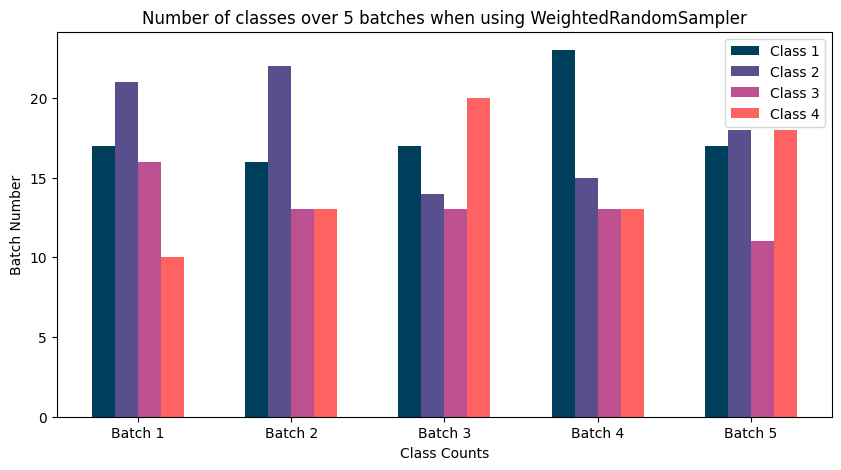

In [94]:
labels = ["Batch " + str(i) for i in range(1, 6)]
counts = [[] for i in range(4)]
for i in range(5):
    images, lab = next(iter(CGAN_dataloader))
    for k, v in Counter(lab.numpy()).items():
        counts[k-1].append(v)
colours = ["#003f5c", "#58508d", "#bc5090", "#ff6361"]

N = 5

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.15  

# Plotting
for i in range(4):
    plt.bar(ind + (width*i), counts[i] , width, label=labels[i], color=colours[i])

plt.xlabel('Class Counts')
plt.ylabel('Batch Number')
plt.title('Number of classes over 5 batches when using WeightedRandomSampler')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + ((width*3) / 2), labels)

# Finding the best position for legends and putting it
plt.legend(loc='best', labels=["Class 1", "Class 2", "Class 3", "Class 4"])
plt.show()

Testing if I can get a non conditional one working

In [95]:
# # Define some parameters
# batch_size = 64
# nz = 100 # Size of z latent vector (i.e. size of generator input)
# ngf = 64 # Size of feature maps in generator
# ndf = 64 # Size of feature maps in discriminator
# num_epochs = 5 # Number of training epochs
# lr = 0.0002 # Learning rate for optimizers
# beta1 = 0.5 # Beta1 hyperparam for Adam optimizers

# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.main = nn.Sequential(
#             # input is Z of size B x nz x 1 x 1, we put this directly into a transposed convolution
#             nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # Size: B x (ngf*4) x 4 x 4
#             nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # Size: B x (ngf*2) x 8 x 8
#             nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # Size: B x (ngf) x 16 x 16
#             nn.ConvTranspose2d( ngf, 1, 4, 2, 1, bias=False),
#             # Size: B x 1 x 32 x 32
#             nn.Tanh()
#         )

#     def forward(self, input):
#         return self.main(input)

# netG = Generator()
# netG = netG.to(device)

# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.main = nn.Sequential(
#             # state size. 1 x 32 x 32
#             nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 16 x 16
#             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 8 x 8
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 4 x 4
#             nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self.main(input)

# netD = Discriminator()
# netD = netD.to(device)

# # Initialize BCELoss function
# criterion = nn.BCELoss()

# # Establish convention for real and fake labels during training
# real_label = 1.
# fake_label = 0.

# # Setup Adam optimizers for both G and D
# optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# # Training Loop

# print("Starting Training Loop...")
# # For each epoch
# for epoch in range(num_epochs):
#     # For each batch in the dataloader
#     for i, (images,labels) in enumerate(CGAN_dataloader, 0):

#         ############################
#         # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
#         ###########################
#         ## Train with all-real batch
#         netD.zero_grad()
#         # Format batch
#         real_images = images.to(device)
#         label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
#         # Forward pass real batch through D
#         output = netD(real_images).view(-1)
#         # Calculate loss on all-real batch
#         errD_real = criterion(output, label)
#         # Calculate gradients for D in backward pass
#         errD_real.backward()
#         D_x = output.mean().item()

#         ## Train with all-fake batch
#         # Generate batch of latent vectors
#         z = torch.randn(batch_size, nz, 1, 1, device=device)
#         # Generate fake image batch with G
#         fake = netG(z)
#         label.fill_(fake_label)
#         # Classify all fake batch with D
#         output = netD(fake.detach()).view(-1)
#         # Calculate D's loss on the all-fake batch
#         errD_fake = criterion(output, label)
#         # Calculate the gradients for this batch, accumulated (summed) with previous gradients
#         errD_fake.backward()
#         D_G_z1 = output.mean().item()
#         # Compute error of D as sum over the fake and the real batches
#         errD = errD_real + errD_fake
#         # Update D
#         optimizerD.step()

#         ############################
#         # (2) Update G network: maximize log(D(G(z)))
#         ###########################
#         netG.zero_grad()
#         label.fill_(real_label)  # fake labels are real for generator cost
#         # Since we just updated D, perform another forward pass of all-fake batch through D
#         output = netD(fake).view(-1)
#         # Calculate G's loss based on this output
#         errG = criterion(output, label)
#         # Calculate gradients for G
#         errG.backward()
#         D_G_z2 = output.mean().item()
#         # Update G
#         optimizerG.step()

#         # Output training stats
#         if i % 50 == 0:
#             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
#                   % (epoch+1, num_epochs, i, len(CGAN_dataloader),
#                      errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

# # Solution
# z = torch.randn(25,nz,1,1,device=device)
# images = netG(z)

# figure = plt.figure(figsize=(10, 8))
# cols, rows = 5, 5
# for i in range(cols * rows):
#     figure.add_subplot(rows, cols, i+1)
#     plt.axis("off")
#     plt.imshow(0.5-0.5*images[i,:].cpu().detach().squeeze(), cmap="gray_r")
# plt.show()

In [96]:
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 5 # Number of training epochs
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers

In [97]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(4,4)
        
        self.model = nn.Sequential(
            nn.Linear(104, 256), # x = torch.cat([z,c], axis=1) ## z.shape == (64,100), c.shape == (64,10), torch.cat([z,c], axis=1).shape == (64,110)
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(1024, 784),
            nn.Tanh()
        )
        
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z,c], axis=1)
        output = self.model(x)
        return output.view(x.size(0), 28, 28)


In [98]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(4,4)
        
        self.model = nn.Sequential(
            nn.Linear(788, 1024), # x = torch.cat([x,c], axis=1) ## x.shape == (64,784), c.shape == (64,10), torch.cat([x,c],axis=1).shape == (64,794)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        c = self.label_emb(labels)
        x = x.view(x.size(0), 784)
        x = torch.cat([x,c], axis=1)
        output = self.model(x)
        return output.squeeze()

generator = Generator().to(device)
discriminator = Discriminator().to(device)

epoch : 0


100%|██████████| 169/169 [00:17<00:00,  9.45it/s]

g_loss : 2.242217540740967, d_loss : 0.48707151412963867
tensor([0, 1, 2, 3])


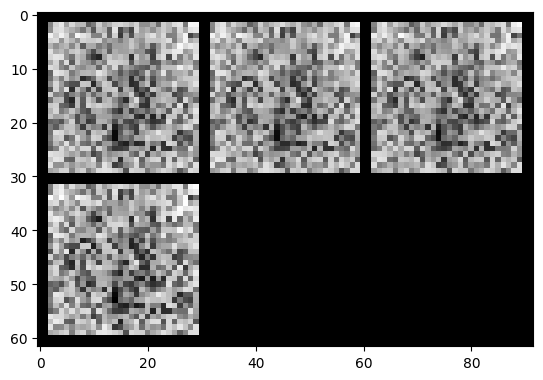

epoch : 1


100%|██████████| 169/169 [00:18<00:00,  9.31it/s]

g_loss : 2.5287845134735107, d_loss : 0.6857643127441406
tensor([0, 1, 2, 3])


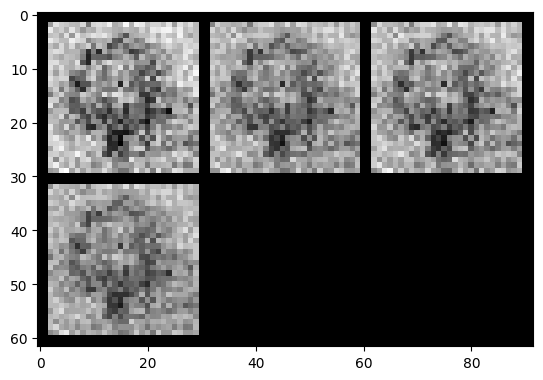

epoch : 2


100%|██████████| 169/169 [00:18<00:00,  9.23it/s]

g_loss : 5.60799503326416, d_loss : 0.14666233956813812
tensor([0, 1, 2, 3])


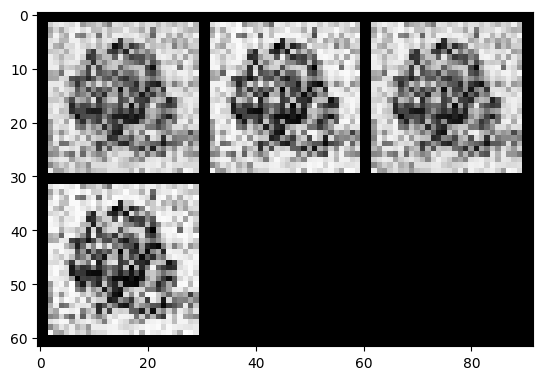

epoch : 3


100%|██████████| 169/169 [00:18<00:00,  9.39it/s]

g_loss : 3.717458724975586, d_loss : 0.18396301567554474
tensor([0, 1, 2, 3])


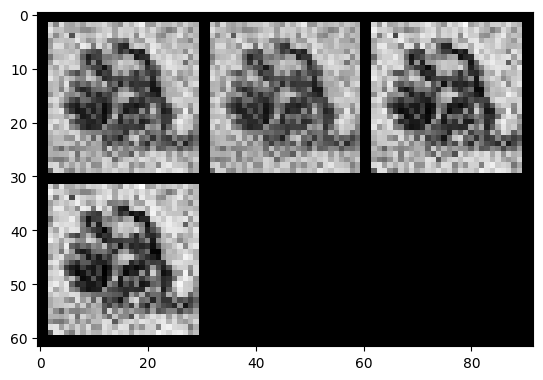

epoch : 4


100%|██████████| 169/169 [00:17<00:00,  9.61it/s]

g_loss : 4.226489067077637, d_loss : 0.10852906107902527
tensor([0, 1, 2, 3])


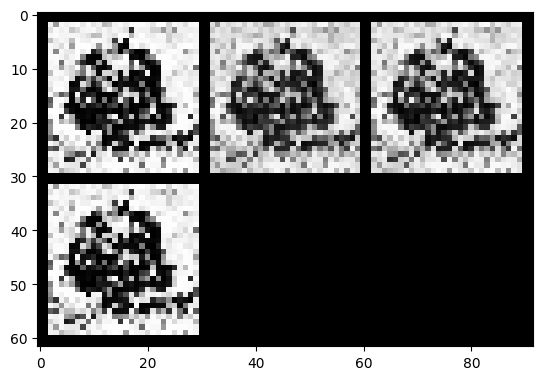

epoch : 5


100%|██████████| 169/169 [00:18<00:00,  9.38it/s]

g_loss : 3.8715837001800537, d_loss : 0.12794114649295807
tensor([0, 1, 2, 3])


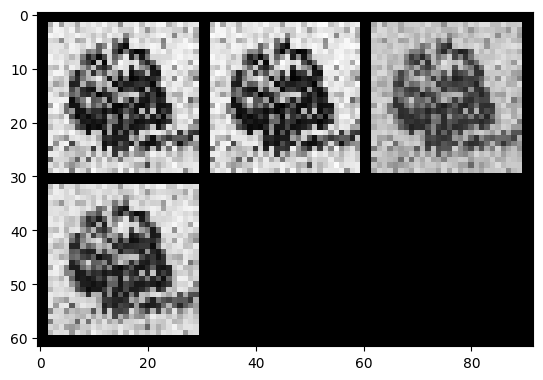

epoch : 6


100%|██████████| 169/169 [00:17<00:00,  9.74it/s]

g_loss : 4.284341335296631, d_loss : 0.5613536238670349
tensor([0, 1, 2, 3])


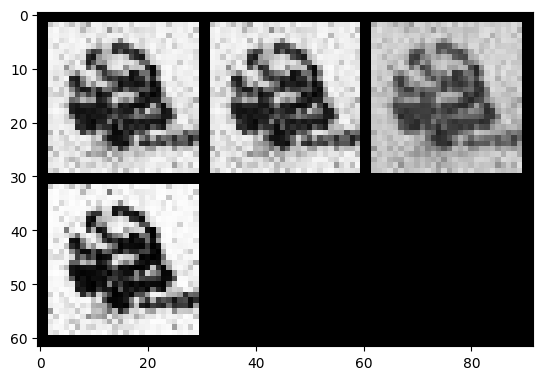

epoch : 7


100%|██████████| 169/169 [00:17<00:00,  9.57it/s]


g_loss : 3.449620008468628, d_loss : 0.5992159843444824
tensor([0, 1, 2, 3])


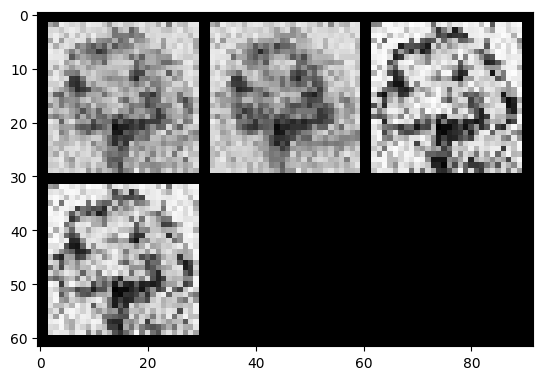

epoch : 8


100%|██████████| 169/169 [00:18<00:00,  9.11it/s]

g_loss : 4.288973808288574, d_loss : 0.40691253542900085
tensor([0, 1, 2, 3])


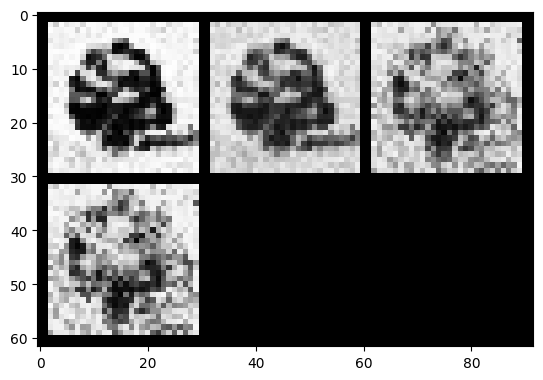

epoch : 9


100%|██████████| 169/169 [00:17<00:00,  9.80it/s]

g_loss : 4.282739162445068, d_loss : 0.40329715609550476
tensor([0, 1, 2, 3])


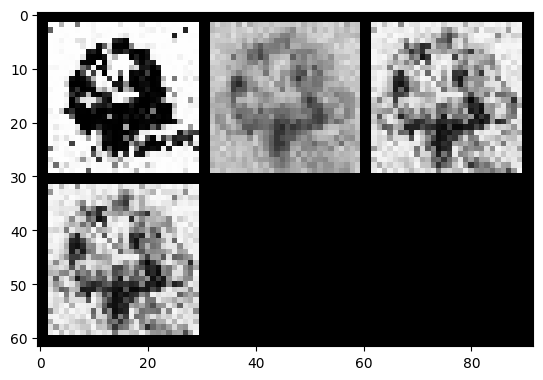

In [99]:
from torch.autograd import Variable
from torchvision.utils import make_grid
real_label, fake_label= 1., 0.

# Initialize BCELoss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
d_optimizer = torch.optim.Adam(
    discriminator.parameters(),
    lr = 1e-4
)
g_optimizer = torch.optim.Adam(
    generator.parameters(),
    lr = 1e-4
)

def train_generator(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size,100)).to(device) # tensor to GPU
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 4, batch_size))).to(device) # tensor to GPU
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels) # valid that is image(generated image by generator) is real or fake
    g_loss = criterion(validity, Variable(torch.ones(batch_size))).to(device) # get loss
    g_loss.backward() # backward pass, back-propagation
    g_optimizer.step() # gradient descent, adjust model parameters
    return g_loss.data

def train_discriminator(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()
    
    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0,4,batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data # get value(scalar)

from tqdm import tqdm

num_epochs = 10
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('epoch : {}'.format(epoch))
    for _, (images, labels) in enumerate(tqdm(CGAN_dataloader)):
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        generator.train()
        batch_size = real_images.size(0)
        d_loss = train_discriminator(len(real_images), discriminator, generator, d_optimizer, criterion, real_images, labels)
        g_loss = train_generator(batch_size, discriminator, generator, g_optimizer, criterion)
        
    generator.eval()
    print('g_loss : {}, d_loss : {}'.format(g_loss, d_loss))
    
    z = Variable(torch.randn(4,100)).to(device)
    labels = Variable(torch.LongTensor(np.arange(4))).to(device)
    print(labels)
    
    sample_images = generator(z, labels).unsqueeze(1).data
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

tensor([0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
tensor([1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)
tensor([2, 2, 2, 2, 2, 2, 2, 2], dtype=torch.int32)
tensor([3, 3, 3, 3, 3, 3, 3, 3], dtype=torch.int32)


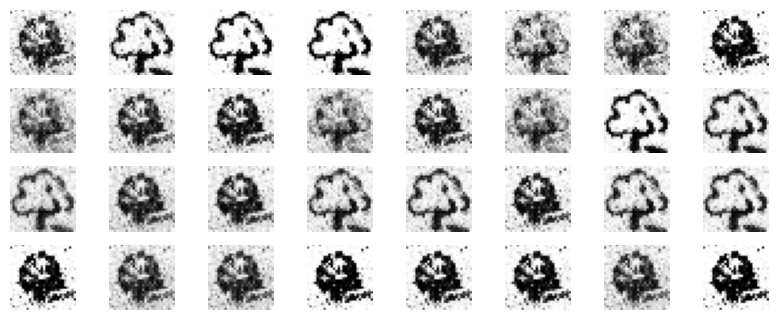

In [100]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for label in range(4):
    z = torch.randn(8,nz,1,1,device=device)
    labels = torch.full((8,), label, dtype=torch.int, device=device)
    print(labels)
    images = generator(z,labels)
    for i in range(8):
        figure.add_subplot(10, 8, label*8+i+1)
        plt.axis("off")
        plt.imshow(0.5-0.5*images[i,:].cpu().detach().squeeze(), cmap="gray_r")
plt.show()

# actual code that will be used fro printing the images below

In [ ]:
%matplotlib inline 
generator.eval()

p = 1
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for label in range(rows):
    z = torch.randn(cols, GEN_INPUT_Z, device=device)
    labels = torch.LongTensor(np.array([label for _ in range(cols)])).to(device)
    print(labels)
    images = generator(z,labels)

    
    for image in images:
        figure.add_subplot(rows, cols, p)
        plt.imshow(image.cpu().detach().squeeze().reshape(28, 28), cmap="gray")
        plt.axis('off')
        plt.title(f"Class - {label+1}")
        p+=1
plt.show()

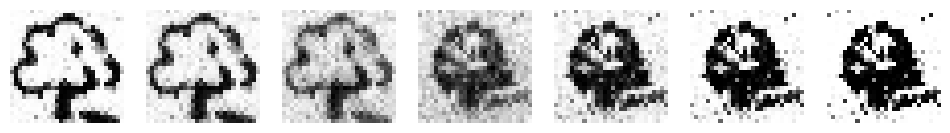

In [106]:
nsamples = 7
z1 = torch.randn(1, nz, 1, 1).to(device)
z2 = torch.randn(1, nz, 1, 1).to(device)
z = torch.zeros(nsamples,nz,1,1).to(device)
for i in range(nsamples):
  w1 = i/(nsamples-1)
  w2 = 1-w1
  z[i,:,:,:] = w1*z1 + w2*z2

images = generator(z, torch.IntTensor([1 for i in range(7)]))

figure = plt.figure(figsize=(12, 4))
for i in range(nsamples):
    figure.add_subplot(1, nsamples, i+1)
    plt.axis("off")
    plt.imshow(0.5-0.5*images[i,:].squeeze().cpu().detach(), cmap="gray_r")
plt.show()